<a href="https://colab.research.google.com/github/yunjeong-chang/2022_PaperReview/blob/main/code/YOLOv3(0504).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# default setting

In [ ]:
cd /content/drive/MyDrive/yolov3/TensorFlow-2.x-YOLOv3

/content/drive/MyDrive/yolov3/TensorFlow-2.x-YOLOv3


In [ ]:
#전체적으로 필요한 것들 import
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, LeakyReLU, ZeroPadding2D, BatchNormalization, MaxPool2D
from tensorflow.keras.regularizers import l2
import colorsys
import random
import matplotlib
import matplotlib.pyplot as plt

# Load_Yolo_model() 

### Create_Yolo()🌟

In [ ]:
def read_class_names(class_file_name):
    # loads class name from a file
    names = {}
    with open(class_file_name, 'r') as data:
        for ID, name in enumerate(data):
            names[ID] = name.strip('\n')
    return names

def mish(x):
    return x * tf.math.tanh(tf.math.softplus(x))

def convolutional(input_layer, filters_shape, downsample=False, activate=True, bn=True, activate_type='leaky'):
    if downsample:
      input_layer = ZeroPadding2D(((1, 0), (1, 0)))(input_layer)
      padding = 'valid'
      strides = 2
    else:
      strides = 1
      padding = 'same'

    conv = Conv2D(filters=filters_shape[-1], kernel_size = filters_shape[0], strides=strides,
                  padding=padding, use_bias=not bn, kernel_regularizer=l2(0.0005),
                  kernel_initializer=tf.random_normal_initializer(stddev=0.01),
                  bias_initializer=tf.constant_initializer(0.))(input_layer)
    if bn:
        conv = BatchNormalization()(conv)
    if activate == True:
        if activate_type == "leaky":
            conv = LeakyReLU(alpha=0.1)(conv)
        elif activate_type == "mish":
            conv = mish(conv) 

    return conv

def residual_block(input_layer, input_channel, filter_num1, filter_num2, activate_type='leaky'):
    short_cut = input_layer
    conv = convolutional(input_layer, filters_shape=(1, 1, input_channel, filter_num1), activate_type=activate_type)
    conv = convolutional(conv, filters_shape=(3, 3, filter_num1, filter_num2), activate_type=activate_type)
    residual_output = short_cut + conv
    return residual_output

def darknet53(input_data):
    input_data = convolutional(input_data, (3, 3, 3, 32))
    input_data = convolutional(input_data, (3, 3, 32, 64), downsample=True)

    for i in range(1):
      input_data = residual_block(input_data, 64, 32, 64)

    input_data = convolutional(input_data, (3, 3, 64, 128), downsample=True)

    for i in range(2):
      input_data = residual_block(input_data, 128, 64,128)

    input_data = convolutional(input_data, (3, 3, 128, 256), downsample=True)

    for i in range(8):
      input_data = residual_block(input_data, 256, 128, 256)

    route_1 = input_data
    input_data = convolutional(input_data, (3, 3, 256, 512), downsample=True)

    for i in range(8):
      input_data = residual_block(input_data, 512, 256, 512)

    route_2 = input_data
    input_data = convolutional(input_data, (3, 3, 512, 1024), downsample=True)

    for i in range(4):
      input_data = residual_block(input_data, 1024, 512, 1024)

    return route_1, route_2, input_data

def upsample(input_layer):
    return tf.image.resize(input_layer, (input_layer.shape[1] * 2, input_layer.shape[2] * 2), method='nearest')

def YOLOv3(input_layer, NUM_CLASS):
    # 3개의 branches
    route_1, route_2, conv = darknet53(input_layer)

    # 총 5개의 Subconvolution 연산
    conv = convolutional(conv, (1, 1, 1024, 512))
    conv = convolutional(conv, (3, 3, 512, 1024))
    conv = convolutional(conv, (1, 1, 1024, 512))
    conv = convolutional(conv, (3, 3, 512, 1024))
    conv = convolutional(conv, (1, 1, 1024, 512))
    conv_lobj_branch = convolutional(conv, (3, 3, 512, 1024))

    # conv_lbbox는 large-sized objects 예측에 사용, Shape = [None, 13, 13, 255] 
    conv_lbbox = convolutional(conv_lobj_branch, (1, 1, 1024, 3*(NUM_CLASS + 5)), activate=False, bn=False)

    conv = convolutional(conv, (1, 1,  512,  256))
    conv = upsample(conv) # upsample은 nearest neighbor interpolation method 사용 --> 네트워크 파라미터 감소

    conv = tf.concat([conv, route_2], axis=-1)
    conv = convolutional(conv, (1, 1, 768, 256))
    conv = convolutional(conv, (3, 3, 256, 512))
    conv = convolutional(conv, (1, 1, 512, 256))
    conv = convolutional(conv, (3, 3, 256, 512))
    conv = convolutional(conv, (1, 1, 512, 256))
    conv_mobj_branch = convolutional(conv, (3, 3, 256, 512))

    # conv_mbbox는 medium-sized objects 예측에 사용, shape = [None, 26, 26, 255]
    conv_mbbox = convolutional(conv_mobj_branch, (1, 1, 512, 3*(NUM_CLASS + 5)), activate=False, bn=False)

    conv = convolutional(conv, (1, 1, 256, 128))
    conv = upsample(conv)

    conv = tf.concat([conv, route_1], axis=-1)
    conv = convolutional(conv, (1, 1, 384, 128))
    conv = convolutional(conv, (3, 3, 128, 256))
    conv = convolutional(conv, (1, 1, 256, 128))
    conv = convolutional(conv, (3, 3, 128, 256))
    conv = convolutional(conv, (1, 1, 256, 128))
    conv_sobj_branch = convolutional(conv, (3, 3, 128, 256))
    
    # conv_sbbox는 small size objects 예측에 사용, shape = [None, 52, 52, 255]
    conv_sbbox = convolutional(conv_sobj_branch, (1, 1, 256, 3*(NUM_CLASS +5)), activate=False, bn=False)
        
    return [conv_sbbox, conv_mbbox, conv_lbbox]

def decode(conv_output, NUM_CLASS, i=0): 
    conv_shape = tf.shape(conv_output)
    batch_size = conv_shape[0]
    output_size = conv_shape[1]
    #import pdb;pdb.set_trace()

    conv_output = tf.reshape(conv_output, (batch_size, output_size, output_size, 3, 5 + NUM_CLASS))

    conv_raw_dxdy, conv_raw_dwdh, conv_raw_conf, conv_raw_prob = tf.split(conv_output, (2, 2, 1, NUM_CLASS), axis=-1)

    xy_grid = tf.meshgrid(tf.range(output_size), tf.range(output_size))
    xy_grid = tf.expand_dims(tf.stack(xy_grid, axis=-1), axis=2)  # [gx, gy, 1, 2]
    xy_grid = tf.tile(tf.expand_dims(xy_grid, axis=0), [batch_size, 1, 1, 3, 1])
    xy_grid = tf.cast(xy_grid, tf.float32)
    
    YOLO_STRIDES = [8, 16, 32]
    YOLO_ANCHORS = [[[10, 13], [16, 30], [33, 23]], #9개의 Anchors
                    [[30, 61], [62, 45], [59, 119]],
                    [[116, 90], [156, 198], [373, 326]]]

    STRIDES = np.array(YOLO_STRIDES)
    ANCHORS = (np.array(YOLO_ANCHORS).T/STRIDES).T

    # prediction box의 중심 위치 예측
    pred_xy = (tf.sigmoid(conv_raw_dxdy) + xy_grid) * STRIDES[i]

    # prediction box의 너비와 높이 예측
    pred_wh = (tf.exp(conv_raw_dwdh) * ANCHORS[i]) * STRIDES[i]

    pred_xywh = tf.concat([pred_xy, pred_wh], axis=-1)
    pred_conf = tf.sigmoid(conv_raw_conf) # confidence 계산
    pred_prob = tf.sigmoid(conv_raw_prob) # probability 계산

    return tf.concat([pred_xywh, pred_conf, pred_prob], axis=-1)

def Create_Yolo(input_size=416, channels=3, training=False, CLASSES="model_data/coco/coco.names"):
    NUM_CLASS = len(read_class_names(CLASSES))
    input_layer = Input([input_size, input_size, channels])

    #YOLOv3 사용
    conv_tensors = YOLOv3(input_layer, NUM_CLASS)

    output_tensors = []
    for i, conv_tensor in enumerate(conv_tensors):
      pred_tensor = decode(conv_tensor, NUM_CLASS, i)
      if training : 
        output_tensors.append(conv_tensor)
      output_tensors.append(pred_tensor)

    Yolo = tf.keras.Model(input_layer, output_tensors)
    #import pdb;pdb.set_trace()
    return Yolo

### load_yolo_weights()

In [ ]:
def load_yolo_weights(model, weights_file):
    tf.keras.backend.clear_session() # used to reset layer names
    # load Darknet original weights to TensorFlow model
    # yolov3 사용
    TRAIN_YOLO_TINY = False
    range1 = 75 if not TRAIN_YOLO_TINY else 13
    range2 = [58, 66, 74] if not TRAIN_YOLO_TINY else [9, 12]
    
    with open(weights_file, 'rb') as wf:
        major, minor, revision, seen, _ = np.fromfile(wf, dtype=np.int32, count=5)

        j = 0
        for i in range(range1):
            if i > 0:
                conv_layer_name = 'conv2d_%d' %i
            else:
                conv_layer_name = 'conv2d'
                
            if j > 0:
                bn_layer_name = 'batch_normalization_%d' %j
            else:
                bn_layer_name = 'batch_normalization'
            
            conv_layer = model.get_layer(conv_layer_name)
            filters = conv_layer.filters
            k_size = conv_layer.kernel_size[0]
            in_dim = conv_layer.input_shape[-1]

            if i not in range2:
                # darknet weights: [beta, gamma, mean, variance]
                bn_weights = np.fromfile(wf, dtype=np.float32, count=4 * filters)
                # tf weights: [gamma, beta, mean, variance]
                bn_weights = bn_weights.reshape((4, filters))[[1, 0, 2, 3]]
                bn_layer = model.get_layer(bn_layer_name)
                j += 1
            else:
                conv_bias = np.fromfile(wf, dtype=np.float32, count=filters)

            # darknet shape (out_dim, in_dim, height, width)
            conv_shape = (filters, in_dim, k_size, k_size)
            conv_weights = np.fromfile(wf, dtype=np.float32, count=np.product(conv_shape))
            # tf shape (height, width, in_dim, out_dim)
            conv_weights = conv_weights.reshape(conv_shape).transpose([2, 3, 1, 0])

            if i not in range2:
                conv_layer.set_weights([conv_weights])
                bn_layer.set_weights(bn_weights)
            else:
                conv_layer.set_weights([conv_weights, conv_bias])

        assert len(wf.read()) == 0, 'failed to read all data'

### Load_Yolo_model() 🌟
<필요한 함수>
1. Create_Yolo() : yolov3의 구조를 만드는 함수
2. load_yolo_weights() : Darknet weights 불러오는 함수

In [ ]:
def Load_Yolo_model():
  
    #gpu관련된 부분
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if len(gpus) > 0:
        print(f'GPUs {gpus}')
        try: tf.config.experimental.set_memory_growth(gpus[0], True)
        except RuntimeError: pass
        
    #YOLO_TYPE == "yolov3"만 남겨버림, configs.py에서 필요한 값만 가져옴
    #원래 조건문 : TRAIN_YOLO_TINY가 True면 YOLO_V3_TINY_WEIGHTS, False면 YOLO_V3_WEIGHTS --> False
    YOLO_V3_WEIGHTS = "model_data/yolov3.weights"
    Darknet_weights = YOLO_V3_WEIGHTS

    #YOLO_CUSTOM_WEIGHTS안 쓸거니까 바로 Darknet weights만 불러옴
    print("Loading Darknet_weights from:", Darknet_weights)
    YOLO_INPUT_SIZE = 416
    YOLO_COCO_CLASSES = "model_data/coco/coco.names"

    #Create_Yolo 함수 필요, load_yolo_weights 함수 필요
    yolo = Create_Yolo(input_size=YOLO_INPUT_SIZE, CLASSES=YOLO_COCO_CLASSES)
    load_yolo_weights(yolo, Darknet_weights) # use Darknet weights

    return yolo

# detect_image() 

### detect_image()에서 필요한 나머지 함수들

In [ ]:
def image_preprocess(image, target_size, gt_boxes=None):
    ih, iw = target_size
    h, w, _ = image.shape

    scale = min(iw/w, ih/h)
    nw, nh = int(scale * w), int(scale * h)
    image_resized = cv2.resize(image, (nw, nh))

    image_paded = np.full(shape=[ih, iw, 3], fill_value=128.0)
    dw, dh = (iw - nw) // 2, (ih-nh) // 2
    image_paded[dh:nh+dh, dw:nw+dw, :] = image_resized
    image_paded = image_paded / 255.

    if gt_boxes is None:
        return image_paded
    else:
        gt_boxes[:, [0, 2]] = gt_boxes[:, [0, 2]] * scale + dw
        gt_boxes[:, [1, 3]] = gt_boxes[:, [1, 3]] * scale + dh
        return image_paded, gt_boxes

def postprocess_boxes(pred_bbox, original_image, input_size, score_threshold):
    valid_scale = [0, np.inf]
    pred_bbox = np.array(pred_bbox)

    pred_xywh = pred_bbox[:, 0:4]
    pred_conf = pred_bbox[:, 4]
    pred_prob = pred_bbox[:, 5:]

    # 1. (x, y, w, h) --> (xmin, ymin, xmax, ymax)
    pred_coor = np.concatenate([pred_xywh[:, :2] - pred_xywh[:, 2:] * 0.5,
                                pred_xywh[:, :2] + pred_xywh[:, 2:] * 0.5], axis=-1)
    
    # 2. (xmin, ymin, xmax, ymax) -> (xmin_org, ymin_org, xmax_org, ymax_org)
    org_h, org_w = original_image.shape[:2]
    resize_ratio = min(input_size / org_w, input_size / org_h)

    dw = (input_size - resize_ratio * org_w) / 2
    dh = (input_size - resize_ratio * org_h) / 2

    pred_coor[:, 0::2] = 1.0 * (pred_coor[:, 0::2] - dw) / resize_ratio
    pred_coor[:, 1::2] = 1.0 * (pred_coor[:, 1::2] - dh) / resize_ratio

    # 3. clip some boxes those are out of range
    pred_coor = np.concatenate([np.maximum(pred_coor[:, :2], [0, 0]),
                                np.minimum(pred_coor[:, 2:], [org_w - 1, org_h - 1])], axis=-1)
    invalid_mask = np.logical_or((pred_coor[:, 0] > pred_coor[:, 2]), (pred_coor[:, 1] > pred_coor[:, 3]))
    pred_coor[invalid_mask] = 0

    # 4. discard some invalid boxes
    bboxes_scale = np.sqrt(np.multiply.reduce(pred_coor[:, 2:4] - pred_coor[:, 0:2], axis=-1))
    scale_mask = np.logical_and((valid_scale[0] < bboxes_scale), (bboxes_scale < valid_scale[1]))

    # 5. discard boxes with low scores
    classes = np.argmax(pred_prob, axis=-1)
    scores = pred_conf * pred_prob[np.arange(len(pred_coor)), classes]
    score_mask = scores > score_threshold
    mask = np.logical_and(scale_mask, score_mask)
    coors, scores, classes = pred_coor[mask], scores[mask], classes[mask]

    return np.concatenate([coors, scores[:, np.newaxis], classes[:, np.newaxis]], axis=-1)

def draw_bbox(image, bboxes, CLASSES="model_data/coco/coco.names", show_label=True, show_confidence = True, Text_colors=(255,255,0), rectangle_colors='', tracking=False):   
    NUM_CLASS = read_class_names(CLASSES)
    num_classes = len(NUM_CLASS)
    image_h, image_w, _ = image.shape
    hsv_tuples = [(1.0 * x / num_classes, 1., 1.) for x in range(num_classes)]
    #print("hsv_tuples", hsv_tuples)
    colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
    colors = list(map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)), colors))

    random.seed(0)
    random.shuffle(colors)
    random.seed(None)

    for i, bbox in enumerate(bboxes):
        coor = np.array(bbox[:4], dtype=np.int32)
        score = bbox[4]
        class_ind = int(bbox[5])
        bbox_color = rectangle_colors if rectangle_colors != '' else colors[class_ind]
        bbox_thick = int(0.6 * (image_h + image_w) / 1000)
        if bbox_thick < 1: bbox_thick = 1
        fontScale = 0.75 * bbox_thick
        (x1, y1), (x2, y2) = (coor[0], coor[1]), (coor[2], coor[3])

        # put object rectangle
        cv2.rectangle(image, (x1, y1), (x2, y2), bbox_color, bbox_thick*2)

        if show_label:
            # get text label
            score_str = " {:.2f}".format(score) if show_confidence else ""

            if tracking: score_str = " "+str(score)

            try:
                label = "{}".format(NUM_CLASS[class_ind]) + score_str
            except KeyError:
                print("You received KeyError, this might be that you are trying to use yolo original weights")
                print("while using custom classes, if using custom model in configs.py set YOLO_CUSTOM_WEIGHTS = True")

            # get text size
            (text_width, text_height), baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_COMPLEX_SMALL,
                                                                  fontScale, thickness=bbox_thick)
            # put filled text rectangle
            cv2.rectangle(image, (x1, y1), (x1 + text_width, y1 - text_height - baseline), bbox_color, thickness=cv2.FILLED)

            # put text above rectangle
            cv2.putText(image, label, (x1, y1-4), cv2.FONT_HERSHEY_COMPLEX_SMALL,
                        fontScale, Text_colors, bbox_thick, lineType=cv2.LINE_AA)
    return image

### nms() 🌟

In [ ]:
def bboxes_iou(boxes1, boxes2):
    boxes1 = np.array(boxes1)
    boxes2 = np.array(boxes2)
    #import pdb;pdb.set_trace()

    boxes1_area = (boxes1[..., 2] - boxes1[..., 0]) * (boxes1[..., 3] - boxes1[..., 1])
    boxes2_area = (boxes2[..., 2] - boxes2[..., 0]) * (boxes2[..., 3] - boxes2[..., 1])

    left_up = np.maximum(boxes1[..., :2], boxes2[..., :2])
    right_down = np.minimum(boxes1[..., 2:], boxes2[..., 2:])

    inter_section = np.maximum(right_down - left_up, 0.0)
    inter_area = inter_section[..., 0] * inter_section[..., 1]
    union_area = boxes1_area + boxes2_area - inter_area
    ious = np.maximum(1.0 * inter_area / union_area, np.finfo(np.float32).eps)

    return ious

def nms(bboxes, iou_threshold, sigma=0.3, method='nms'):
    classes_in_img = list(set(bboxes[:, 5]))
    best_bboxes = []
    #import pdb;pdb.set_trace()

    for cls in classes_in_img:
      cls_mask = (bboxes[:, 5] == cls)
      cls_bboxes = bboxes[cls_mask]
      # Process 1: bounding boxes의 수가 0보다 큰지 확인
      while len(cls_bboxes) > 0: 
        # Process 2: 가장 높은 점수를 가진 bounding boxes 선택
        max_ind = np.argmax(cls_bboxes[:, 4])
        best_bbox = cls_bboxes[max_ind]
        best_bboxes.append(best_bbox)
        cls_bboxes = np.concatenate([cls_bboxes[: max_ind], cls_bboxes[max_ind + 1:]])
        # Process 3: bboxes_iou 함수 - iou값이 threshold보다 높은 bounding box는 제거
        iou = bboxes_iou(best_bbox[np.newaxis, :4], cls_bboxes[:, :4])
        weight = np.ones((len(iou),), dtype=np.float32)

        assert method in ['nms', 'soft-nms']
        if method == 'nms':
          iou_mask = iou > iou_threshold
          weight[iou_mask] = 0.0
        if method == 'soft-nms':
          weight = np.exp(-(1.0 * iou ** 2 / sigma))

        cls_bboxes[:, 4] = cls_bboxes[:, 4] * weight
        score_mask = cls_bboxes[:, 4] > 0.
        cls_bboxes = cls_bboxes[score_mask]

    return best_bboxes

### detect_image()
<필요한 함수>
1. image_preprocess()
2. postprocess_boxes()
3. nms(), bboxes_iou()
4. draw_bbox()

In [ ]:
def detect_image(Yolo, image_path, output_path, input_size=416, show=False, CLASSES="model_data/coco/coco.names", score_threshold=0.3, iou_threshold=0.45, rectangle_colors=''):
    original_image = cv2.imread(image_path)
    #original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
    #original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB) #반복해야 정상 출력

    image_data = image_preprocess(np.copy(original_image), [input_size, input_size])
    image_data = image_data[np.newaxis, ...].astype(np.float32)
    
    #YOLO_FRAMEWORK == "tf"
    pred_bbox = Yolo.predict(image_data)
        
    pred_bbox = [tf.reshape(x, (-1, tf.shape(x)[-1])) for x in pred_bbox]
    pred_bbox = tf.concat(pred_bbox, axis=0)
    
    bboxes = postprocess_boxes(pred_bbox, original_image, input_size, score_threshold)
    bboxes = nms(bboxes, iou_threshold, method='nms')
    #import pdb;pdb.set_trace()
    image = draw_bbox(original_image, bboxes, CLASSES=CLASSES, rectangle_colors=rectangle_colors)
    
    if output_path != '': cv2.imwrite(output_path, image)
    if show:
      #cv2.imshow("predicted image", image)
      cv2.waitKey(0)
      cv2.destroyAllWindows()
        
    return image

# detection_demo.py 🌟
<필요한 함수>
1. Load_Yolo_model() : yolov3의 구조를 만들고, weights를 불러오는 함수
2. detect_image() : 이미지를 yolov3 모델에 태우고, nms 진행한 후 최종 결과 박스들을 그리는 함수

Loading Darknet_weights from: model_data/yolov3.weights


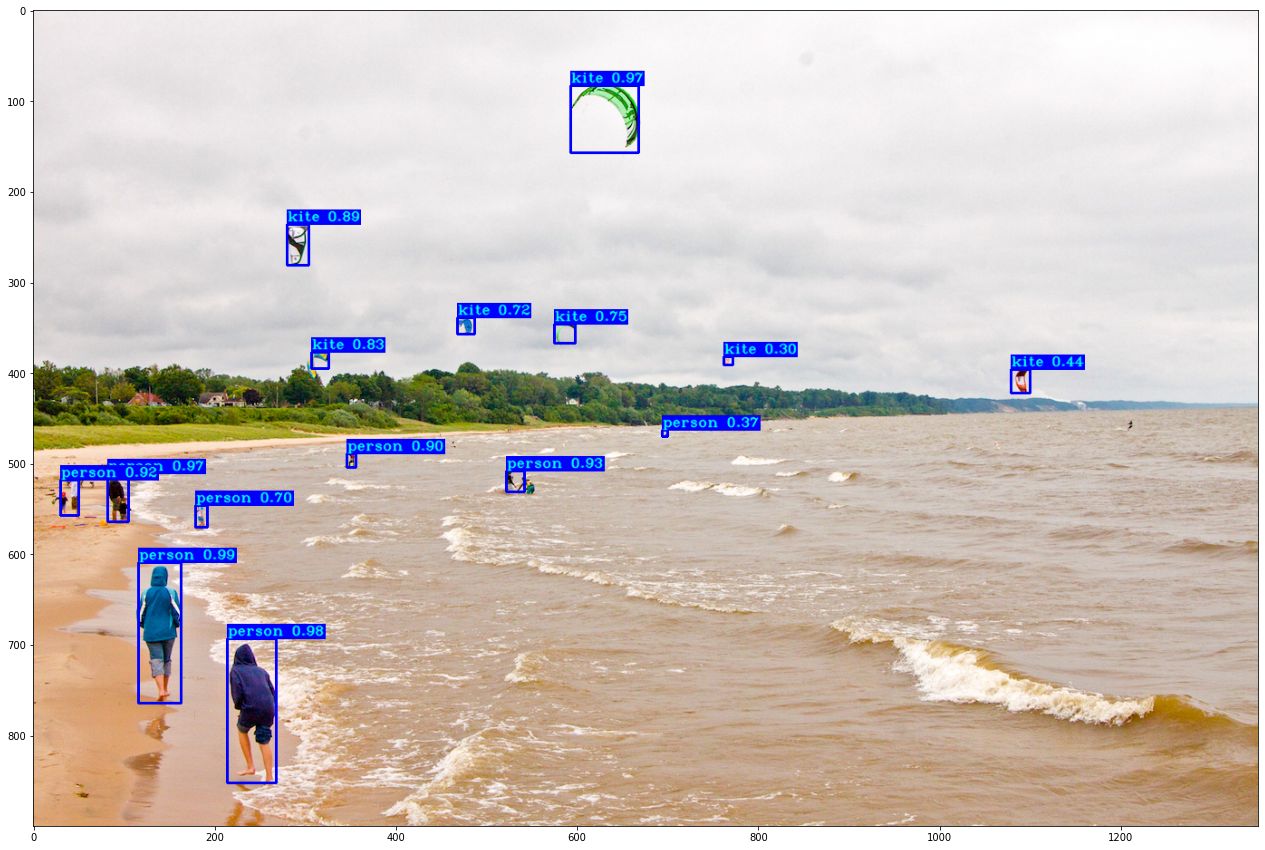

In [ ]:
#from yolov3.utils import detect_image, Load_Yolo_model
#from yolov3.configs import *

yolo = Load_Yolo_model()

image_path = "./IMAGES/kite.jpg"
output_path = "./IMAGES/kite_pred.jpg"
image = detect_image(yolo, image_path, output_path, input_size=416, show=True, rectangle_colors=(255,0,0))

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(30,15))
plt.imshow(image)